##Prototypes for SSO metrics and plots. ##

This notebook assumes you have downloaded or generated some files which contain the orbits for a set of SSOs and the observations of each SSO (in a particular opsim run) coupled with the opsim values for each visit. When this gets into "MAF proper", the columns for the opsim visits should be computed automatically from the list of metrics; for now, the opsim values provided for each visit are 

    expMJD night fieldRA fieldDec (radians) filter rotSkyPos seeing fiveSigmaDepth  

and the values for each SSO are 

    ObjID ra dec (degrees) dra/dt ddec/dt distance Vmag (assumes H=20 if H not specified) dmagColor (to convert to the filter) dmagTrailing (based on velocity)
    
Some sample files are available at http://www.astro.washington.edu/users/lynnej/sso/ for MBAs, TNOs and PHAs.
For each of these sets of files, the orbits file either has no suffix (and is a subset of objects from the S3M model) or ends with .des (for a pha sample, of the largest NEOs from the MPC). 
The observation files (ending with `_allObs.txt`) are created by the [proto_make_obs.py](https://github.com/rhiannonlynne/MafSSO/blob/master/proto_make_obs.py) script or a slightly modified version [here](https://github.com/rhiannonlynne/MafSSO/blob/master/proto_make_obs2.py) (for S3M input files).

---
Read in the orbits and observations. We're not using maf modules here yet, because these metrics are not yet integrated into the framework. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [168]:
#orbitfile = 'mbas_1000.txt'
orbitfile = 'pha20141031.des'
obsfile = orbitfile.replace('.des', '').replace('.txt','') + '_allObs.txt'

orbits = pd.read_table(orbitfile, sep='\s*')
orbits = orbits.to_records()

obs = pd.read_table(obsfile, sep='\s*')
obs = obs.to_records()

Let's make two example metrics, for the number of observations of each object and for the number of discovery chances.

In [169]:
def nObsMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5):
    # Given the observations for a particular object and the opsim metadata:
    # Return the number of observations above SNR (in any band) as a function of H
    countObs = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return countObs
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        countObs[i] = np.where(snr >= snrLimit)[0].size
    return countObs

In [170]:
def DiscoveryMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, nObsPerNight=2, window=15):
    # Given the observations for a particular object and the opsim metadata (join using joinObs)
    # Return the number possibilities for 'discovery' of the object, as a function of H
    discoveryChances = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return discoveryChances
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        vis = np.where(snr>=snrLimit)[0]
        if len(vis) == 0:
            discoveryChances[i] = 0
        else:
            # Now to identify where observations meet the timing requirements.
            # Where the 'night' info. Identify visits where the 'night' changes.
            nightChangeIdx = np.where(ssoObs['night'][vis][1:] != ssoObs['night'][vis][:-1])[0]
            nightChangeIdx = np.concatenate([np.array([vis[0]], int), nightChangeIdx+1])
            # Look at difference in index values: if difference is > nObsPerNight, this is a 'good' night.
            moreThanXIdx = np.where(np.abs(nightChangeIdx[1:] - nightChangeIdx[:-1]) >= nObsPerNight)[0]
            if len(ssoObs['night'][vis]) - nightChangeIdx[-1] >= nObsPerNight:
                moreThanXIdx = np.concatenate([moreThanXIdx, np.array([len(nightChangeIdx)-1], int)])
            nightsWithMoreThanX = ssoObs['night'][nightChangeIdx][moreThanXIdx]
            # Look at intervals between 'good' nights. 
            windowIdx = np.where(np.abs(nightsWithMoreThanX[2:] - nightsWithMoreThanX[:-2]) <= window)[0]
            nightsInWindow = ssoObs['night'][nightChangeIdx][moreThanXIdx][windowIdx]
            discoveryChances[i] = nightsInWindow.size
    return discoveryChances

Define 'Completeness' as the equivalent of a summary statistic, to run on the results of 'DiscoveryChances'. 

In [171]:
def Completeness(discoveryChances, Hrange, numSsos):
    completeness = np.zeros(len(Hrange), float)
    discoveries = discoveryChances.swapaxes(0, 1)
    for i, H in enumerate(Hrange):
        completeness[i] = np.where(discoveries[i] >= 1)[0].size
    completeness = completeness/float(numSsos)
    return completeness

Run metrics (call the metric once for each object, passing all observations). 

In [172]:
ssoID = '!!ObjID'
ssoID_orbit = ssoID
if ssoID_orbit not in orbits.dtype.names:
    ssoID_orbit = '!!OID'

ssoids = orbits[ssoID_orbit]
if len(ssoids) != len(np.unique(orbits[ssoID_orbit])):
    print "Orbit id's are repeated!"

In [173]:
# Set up to run metrics. 
Hrange = np.arange(13, 27, 0.25)
sNum = float(len(ssoids))

nobsSsos = np.zeros([len(ssoids), len(Hrange)], int)
discoveries = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    nobsSsos[i] = nObsMetric(ssoObs, Hrange=Hrange)
    discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange)
    
completeness = Completeness(discoveries, Hrange, sNum)

We may want to plot the metric results as function of H, after summing/averaging/etc. over the metric values for each individual object. 

In [174]:
def metricVsH(metricVals, Hrange, npmethod=np.mean, label='Mean', fignum=None):
    fig = plt.figure(fignum)
    if npmethod is not None:
        vals = npmethod(metricVals, axis=0)
    else:
        vals = metricVals
    plt.plot(Hrange, vals, label=label)
    plt.xlabel('H (mag)')
    return fig.number

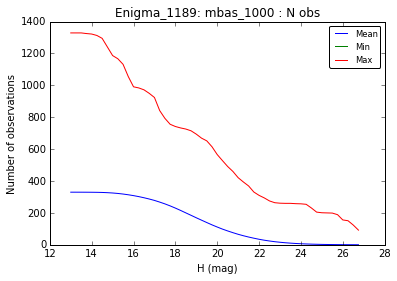

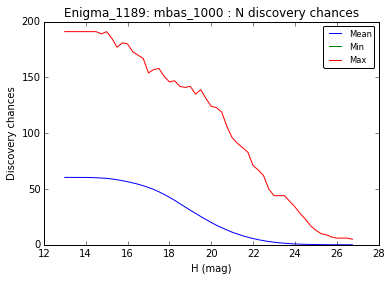

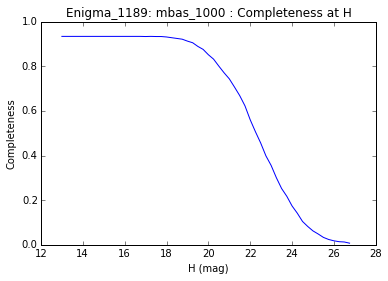

In [175]:
fignum = metricVsH(nobsSsos, Hrange)
fignum = metricVsH(nobsSsos, Hrange, np.min, label='Min', fignum=fignum)
fignum = metricVsH(nobsSsos, Hrange, np.max, label='Max', fignum=fignum)
plt.legend(fontsize='small', fancybox=True)
plt.ylabel('Number of observations')
plt.title('Enigma_1189: %s : %s' %(outroot, 'N obs'))

fignum = metricVsH(discoveries, Hrange)
fignum = metricVsH(discoveries, Hrange, np.min, label='Min', fignum=fignum)
fignum = metricVsH(discoveries, Hrange, np.max, label='Max', fignum=fignum)
plt.legend(fontsize='small', fancybox=True)
plt.ylabel('Discovery chances')
plt.title('Enigma_1189: %s : %s' %(outroot, 'N discovery chances'))

fignum = metricVsH(completeness, Hrange, None)
plt.ylabel('Completeness')
plt.title('Enigma_1189: %s : %s' %(outroot, 'Completeness at H'))

When we interpret the above results, sometimes we want to be able to integrate over H (to give metric results at H <= X rather than just at H=X).

For the size distribution, assume a power law. 
 \begin{equation}
 dN / dH \propto 10^{\alpha \, (H-H_0)}
 \end{equation}

In [176]:
def integrateH(summaryVals, Hrange, Hindex=0.3):
    # Set expected H distribution. 
    # dndh = differential size distribution (number in this bin)
    dndh = np.power(10., Hindex*(Hrange-Hrange.min()))
    # dn = cumulative size distribution (number in this bin and brighter)
    dn = np.cumsum(dndh)
    intVals = np.cumsum(summaryVals*dndh)/dn
    return intVals

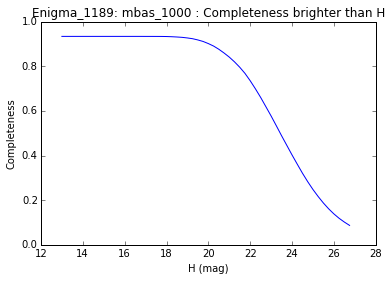

In [177]:
compH = integrateH(completeness, Hrange)
fignum = metricVsH(compH, Hrange, None)
plt.ylabel('Completeness')
plt.title('Enigma_1189: %s : %s' %(outroot, 'Completeness brighter than H'))

Also we want to be able to generate plots of metric value vs. orbital parameters. 

In [178]:
def metricVs2dOrbits(orbits, xlabel, ylabel, 
                     metricVals, Hval, Hrange,
                     xbinsize=None, ybinsize=None, nxbins=None, nybins=None,
                     ssoID='!!ObjID', ssoID_orbit='!!ObjID'):
    xvals = orbits[xlabel]
    yvals = orbits[ylabel]
    xmin = xvals.min()
    ymin = yvals.min()
    if (xbinsize!=None) & (ybinsize!=None):
        xbins = np.arange(xmin, np.max(xvals), xbinsize)
        ybins = np.arange(ymin, np.max(yvals), ybinsize)
        nxbins = xbins.shape[0]
        nybins = ybins.shape[0]
    elif (nxbins!=None) & (nybins!=None):
        xbinsize = (np.max(xvals) - xmin)/float(nxbins)
        ybinsize = (np.max(yvals) - ymin)/float(nybins)
        xbins = np.arange(xmin, np.max(xvals), xbinsize)
        ybins = np.arange(ymin, np.max(yvals), ybinsize)
        nxbins = xbins.shape[0]
        nybins = ybins.shape[0]
    else:
        raise ValueError('Must specify either binsize or nbins')
    # Set up to calculate summary values at each x/y binpoint. 
    summaryVals = np.zeros((nybins, nxbins), dtype='float')
    summaryNums = np.zeros((nybins, nxbins), dtype='int')
    Hidx = np.where(Hrange == Hval)[0]
    # Metrics are evaluated in the order of the orbits. 
    for i, orbit in enumerate(orbits):
        x = orbit[xlabel]
        y = orbit[ylabel]
        xidx = np.min([int((x - xmin)/xbinsize), nxbins-1])
        yidx = np.min([int((y - ymin)/ybinsize), nybins-1])
        summaryVals[yidx][xidx] += metricVals[i][Hidx]
        summaryNums[yidx][xidx] += 1
    summaryVals = np.where(summaryNums != 0, summaryVals / summaryNums, 0)
    # Create 2D x/y arrays, to match 2D counts array.
    xi, yi = np.meshgrid(xbins, ybins)
    # Plot. 
    plt.figure()
    levels = np.arange(summaryVals.min(), summaryVals.max(), (summaryVals.max() - summaryVals.min())/200.0)
    plt.contourf(xi, yi, summaryVals, levels, extend='max')
    cbar = plt.colorbar()
    cbar.set_label('Mean')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

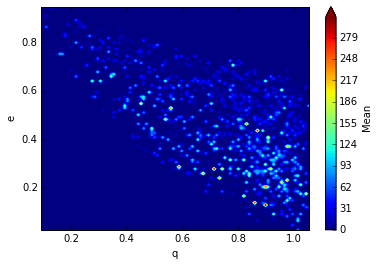

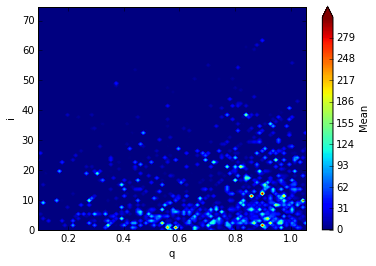

In [180]:
metricVs2dOrbits(orbits, 'q', 'e', nobsSsos, 22.0, Hrange, nxbins=100, nybins=100)
metricVs2dOrbits(orbits, 'q', 'i', nobsSsos, 22.0, Hrange, nxbins=100, nybins=100)